In [1]:
import os
import numpy as np
from PIL import Image
import argparse
import cv2
import scipy.sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import imutils
import pandas as pd

import itertools
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

import time
import random
import math

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

!conda info --env

%matplotlib inline



# conda environments:
#
base                     C:\Users\yongwook\anaconda3
outline               *  C:\Users\yongwook\anaconda3\envs\outline



In [2]:

import sys



def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

# ML Playground (CNN, mostly)

## Creating Dataset
Based on above information, we can create custom dataset. 사실 Dataset만 상속받고 나머지는 알아서 잘 해도 된다 하더라.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://blog.paperspace.com/dataloaders-abstractions-pytorch/
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html



In [4]:
class PatchLandmarkDataSet(Dataset):


    def __init__(self, data_dir: str, image_postfix:str, tsv_postfix:str, landmark_name:str):
        

        self.photo_img_string = image_postfix
        self.photo_tsv_string = tsv_postfix
        self.data_dir = data_dir
        self.landmark_name = landmark_name

        files = os.listdir(self.data_dir)

        self.photo_images = [x for x in files if self.photo_img_string in x]
        self.photo_tsvs = [x for x in files if self.photo_tsv_string in x]
        assert(len(self.photo_images) == len(self.photo_tsvs))
        for i in range(len(self.photo_images)):
            x, y = self.photo_images[i], self.photo_tsvs[i]
            assert(os.path.splitext(x)[0] == os.path.splitext(y)[0])

    def __len__(self):
        return len(self.photo_tsvs)

    # load_tsv: load tsv --> return dataframe with name, x, y column.
    def load_tsv(self, name):
        # Loading dataframe
        df = pd.read_csv(os.path.join(self.data_dir, name),  sep='\t')
        df = df.iloc[:99, 0:3]
        
        df.columns = ['name', 'X', 'Y']

        return df


    # load_image: load image --> return plt.Image grayscale.
    def load_image(self, name):
        image = cv2.imread(os.path.join(self.data_dir, name), flags=cv2.IMREAD_GRAYSCALE)
        img = Image.fromarray(image)
        return img


    def extract_landmark(self, df):
        df = df.loc[df['name'] == self.landmark_name]
        df = df.loc[:, ['X', 'Y']]
        df = df.reset_index(drop=True)

        landmark = df.to_numpy(dtype=np.float32)
        return landmark

    # bounding_box: landmark --> return top, left, height, width
    def bounding_box(self, landmark):
        cx, cy = landmark[0]
        width, height = random.randint(80, 160), random.randint(80, 160)
        
        top, left = cy - random.randint(0, height), cx - random.randint(0, width)

        return int(top), int(left), int(height), int(width)

    def rotate(self, img, landmark, angle):
        angle = random.uniform(-angle, +angle)

        
        transformation_matrix = torch.tensor([
            [+math.cos(math.radians(angle)), -math.sin(math.radians(angle))], 
            [+math.sin(math.radians(angle)), +math.cos(math.radians(angle))]
        ])

        image = imutils.rotate(np.array(img), angle)

        landmark = landmark - 0.5
        new_landmarks = np.matmul(landmark, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def crop(self, img, landmark, top, left, height, width):
        # Cropping image...
        img = TF.crop(img, top, left, height, width)
        #oh, ow = np.array(img).shape[0], np.array(img).shape[1]

        landmark = torch.tensor(landmark) - torch.tensor([[left, top]])
        landmark = landmark / torch.tensor([width, height])
        return img, landmark

    def normalize(self, img, landmark):
        # normalizing the pixel values
        img = TF.to_tensor(img)
        img = TF.normalize(img, [0.6945], [0.33497])


        landmark -= 0.5
        return img, landmark

    def __getitem__(self, index):
        
        img_name = self.photo_images[index]
        tsv_name = self.photo_tsvs[index]

        img = self.load_image(img_name)
        df = self.load_tsv(tsv_name)
        landmark = self.extract_landmark(df)
        top, left, height, width = self.bounding_box(landmark)

        img, landmark = self.crop(img, landmark, top, left, height, width)

        # resizing image..
        img = TF.resize(img, (224, 224))
        # packing image
        # use dsplit when RGB to make 224x224x3 --> 3x224x224
        #img = np.dsplit(img, img.shape[-1])

        img, landmark = self.rotate(img, landmark, 10)
        img, landmark = self.normalize(img, landmark)

        #arr = arr.flatten('F')

        return img, landmark

In [3]:
data_dir = "./AutoAlign"
test_dir = "./AutoAlign_test"
weights_path = 'face_landmarks_patch_'

landmark_name = '29@2' # '29@[2479]|30@[34]' # for 18: '29@[1-9]\d?|30@[1-7]'

photo_postfix = "lat_photo.jpg"
tsv_postfix = "lat_photo.txt"

dataset =  PatchLandmarkDataSet(data_dir, photo_postfix, tsv_postfix, landmark_name)
test_dataset = PatchLandmarkDataSet(test_dir, photo_postfix, tsv_postfix, landmark_name)
# split the dataset into validation and test sets
len_valid_set = len(test_dataset)
len_train_set = len(dataset)

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

data_train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
print(len(data_train_loader))

valid_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

NameError: name 'PatchLandmarkDataSet' is not defined

Feature batch shape: torch.Size([64, 1, 224, 224])
Labels batch shape: torch.Size([64, 1, 2])
Label: tensor([[-0.4423, -0.3419]])
landmarks: tensor([[12.9241, 35.4165]])


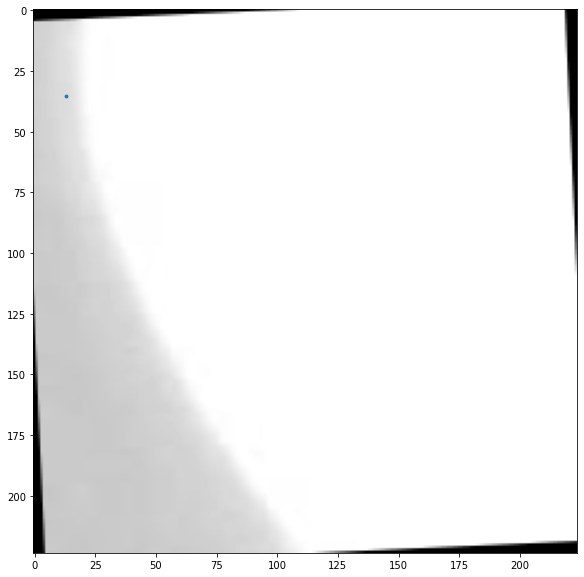

In [6]:
# Display image and label.
train_features, train_labels = next(iter(data_train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]

print(f"Label: {label}")
landmarks = (label + 0.5) * 224
print(f"landmarks: {landmarks}")
plt.figure(figsize=(10, 10))
plt.imshow(img.squeeze(), cmap='gray')
plt.scatter(landmarks[:,0], landmarks[:,1], s=8)


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Network
Based on https://colab.research.google.com/drive/1-28T5nIAevrDo6MwN0Qi_Cgdy9TEiSP_?usp=sharing#scrollTo=XH_bqPXo6YG8

Resnext50을 이용한다. 일단은 Greyscale(컬러로 확장도 가능하나 실익이 크지 않다.)

https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4

In [4]:
class Network(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.model_name='resnet50'
        #self.model=models.resnet18(pretrained=True)
        self.model=models.resnet50(pretrained=True)


        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # for param in self.parameters():
        #     param.requires_grad = False

        # RGB:        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

        
    def forward(self, x):
        x=self.model(x)
        return x

## Training
그림이 커서 그런지 초반에는 구데기로 나오고, 최소 100 epoch 이상은 해 줘야 할 것 같다.

- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- http://incredible.ai/artificial-intelligence/2017/05/13/Transfer-Learning/#%EC%83%88%EB%A1%9C-%ED%9B%88%EB%A0%A8%ED%95%A0-%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B0%80-%EC%A0%81%EC%9C%BC%EB%A9%B0-original-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%99%80-%EB%8B%A4%EB%A5%B8-%EA%B2%BD%EC%9A%B0
- https://hanqingguo.github.io/Face_detection


In [9]:
# %%capture cap_out --no-stderr

torch.autograd.set_detect_anomaly(True)
network = Network()
# use load_state_dict to load previously trained model.
# checkpoint = torch.load(f"model/0518_1226_6_100_face_landmarks_transfer_resnext50.tar"))
# use pth only
# network.load_state_dict(torch.load(f"model/0525_1926_6_100_face_landmarks_transfer__resnext50.pth"))
# use checkpoint
# network.load_state_dict(checkpoint['network_state_dict'])

network.cuda()
print(network)

criterion = nn.MSELoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, network.parameters()), lr=0.001)
# Load optimizer too
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

loss_min = np.inf
num_epochs = 100

logger = pd.DataFrame(columns=['train loss', 'valid loss'])

start_time = time.time()
time_str = time.strftime(f"%m%d_%H%M")
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(data_train_loader)+1):
    
        images, landmarks = next(iter(data_train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        optimizer.zero_grad()
        
        loss_train_step = criterion(predictions, landmarks)
        
        loss_train_step.backward()
        
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(data_train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(data_train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    logger.loc[epoch - 1] = [loss_train, loss_valid]

    if loss_valid < loss_min:
        loss_min = loss_valid
        # torch.save(network.state_dict(), f"model/{time_str}_{landmark_number}_{num_epochs}_{weights_path}_{network.model_name}.pth") 
        torch.save({
            'network_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, f"model/{time_str}_{landmark_name}_{num_epochs}_{weights_path}_{network.model_name}.tar")
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
    
    # cap_out.show()
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
logger.to_csv(f'csv/{time_str}_{landmark_name}_{num_epochs}_{weights_path}_train_data.csv')
# cap_out.show()
# with open(f'csv/{time_str}_{landmark_number}_{num_epochs}_train_log.txt') as capture_file:
#     capture_file.write(cap_out)



KeyboardInterrupt: 

In [6]:
def pixel_distance(landmark, reference):
    ''' pixel_distance(landmark: np.array[[x, y], ..] 
                        reference: np.array[[x, y]] with true landmark value

        return: average: float average distance,
                each: np.array[distance, ..] with distance of each landmark
    '''
    each = []
    for i in range(len(landmark)):
        each.append(np.linalg.norm(landmark[i] - reference[i]))

    each = np.array(each)
    average = np.average(each)

    return average, each


77.12213
[77.12213]
76.465126
[76.465126]
61.048904
[61.048904]
38.681107
[38.681107]
141.01897
[141.01897]
26.293432
[26.293432]
37.25666
[37.25666]
23.708183
[23.708183]
Total number of test images: 50
Elapsed Time : 1.7429306507110596


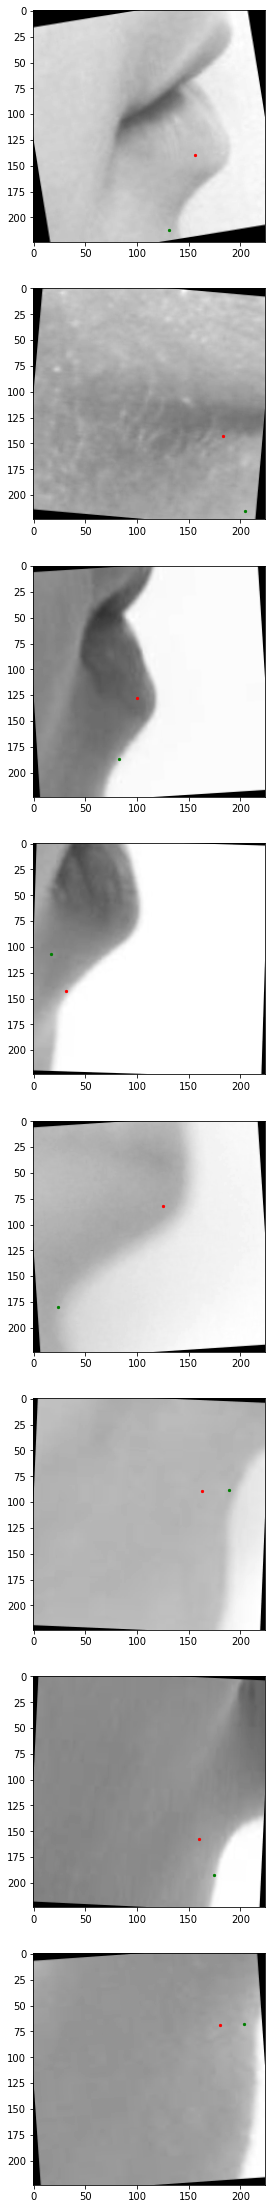

In [66]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load(f"model/{time_str}_{landmark_name}_{num_epochs}_{weights_path}_{network.model_name}.tar")['network_state_dict'])
    # best_network.load_state_dict(torch.load(f"model/0528_1615_29@7_100_face_landmarks_patch__resnext50.tar")['network_state_dict'])
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    landmarks = (landmarks+0.5) * 224
    images = images.cuda()

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,1,2)


    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

        average, each = pixel_distance(predictions[img_num], landmarks[img_num])
        print(average)
        print(each)


print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

## From Face detection to landmark detection, IRL

https://github.com/timesler/facenet-pytorch

- With pip:
pip install facenet-pytorch

- or clone this repo, removing the '-' to allow python imports:
git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

- or use a docker container (see https://github.com/timesler/docker-jupyter-dl-gpu):
docker run -it --rm timesler/jupyter-dl-gpu pip install facenet-pytorch && ipython

In [7]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data, 0))
    mdev = np.median(d, 0)
    s = d/mdev if mdev.all() else np.array([0, 0])
    sqsum = (s[:,0] * s[:, 0] + s[:, 1] * s[:, 1]) ** 0.5
    return data[sqsum<m]

In [8]:
from facenet_pytorch import MTCNN, InceptionResnetV1

start = time.time()

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=224, device=device)

#######################################################################
image_path = 'AutoAlign/0001___________000_lat_photo.jpg'

patch_size = 80
patch_size_upper = 160

#######################################################################
base_network = Network(num_classes=12)
base_network.load_state_dict(torch.load(f"model/0602_1303_6_100_face_landmarks_transfer__resnet50.tar")['network_state_dict'])
# base_network.load_state_dict(torch.load(f"model/0518_1226_6_100_face_landmarks_transfer_resnext50.pth"))
base_network.eval()


image_open = time.time()
input_image = Image.open(image_path)
grayscale_image = input_image.convert('L')
height, width = input_image.size[0], input_image.size[1]
print(height, width)
# Get cropped and prewhitened image tensor
boxes, probs = mtcnn.detect(input_image)
face = boxes[0]
x0, y0, x1, y1 = face
x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1) 

#face = (faces + 1) * 255

# image = np.array(grayscale_image)
# image = image[y0:y1, x0:x1]
# image = TF.crop(grayscale_image, y0, x0, y1-y0, x1-x0)
image = TF.resized_crop(grayscale_image, y0, x0, y1-y0, x1-x0, size=(224, 224))
# plt.imshow(image, cmap='gray')
# plt.imsave("profile_cut.png", image, cmap='gray')
# image = TF.resize(Image.fromarray(image), size=(224, 224))
image = TF.to_tensor(image)
image = TF.normalize(image, [0.6945], [0.33497])
from_image_inference = time.time()
with torch.no_grad():
   landmarks = base_network(image.unsqueeze(0))

# second inference using landmark and bounding box
# use for i in range(6) for real case.
# for testing, testing using landmarks[0,0:2]
patch_nets = []
patch_net0 = Network(num_classes=2)
patch_net0.load_state_dict(torch.load(f"model/0602_1419_29@2_100_face_landmarks_patch__resnet50.tar")['network_state_dict'])
patch_net0.eval()
patch_nets.append(patch_net0)

# patch_net1 = Network(num_classes=2)
# patch_net1.load_state_dict(torch.load(f"model/0528_1418_29@4_100_face_landmarks_patch__resnext50.tar")['network_state_dict'])
# patch_net1.eval()
# patch_nets.append(patch_net1)

# patch_net2 = Network(num_classes=2)
# patch_net2.load_state_dict(torch.load(f"model/0528_1615_29@7_100_face_landmarks_patch__resnext50.tar")['network_state_dict'])
# patch_net2.eval()
# patch_nets.append(patch_net2)

# patch_net3 = Network(num_classes=2)
# patch_net3.load_state_dict(torch.load(f"model/0529_1908_29@9_100_face_landmarks_patch__resnext50.tar")['network_state_dict'])
# patch_net3.eval()
# patch_nets.append(patch_net3)

# patch_net4 = Network(num_classes=2)
# patch_net4.load_state_dict(torch.load(f"model/0529_2015_30@3_100_face_landmarks_patch__resnext50.tar")['network_state_dict'])
# patch_net4.eval()
# patch_nets.append(patch_net4)

# patch_net5 = Network(num_classes=2)
# patch_net5.load_state_dict(torch.load(f"model/0529_2119_30@4_100_face_landmarks_patch__resnext50.tar")['network_state_dict'])
# patch_net5.eval()
# patch_nets.append(patch_net5)

print(len(patch_nets))

landmark_means = []

print(landmarks)
landmarks = (landmarks.view(6, 2).detach().numpy() + 0.5) * np.array([[x1-x0, y1-y0]]) + np.array([[x0, y0]])

for i in range(0, len(patch_nets), 1):

   x, y = landmarks[i, 0:2]
   patches = torch.tensor(())
   patches = patches.new_empty([10, 1, 224, 224])
   print(patches.shape)
   single_landmarks = []
   width_height = np.empty([10, 2])
   top_left = np.empty([10, 2])
   for j in range(10):
      h, w = random.randint(patch_size, patch_size_upper), random.randint(patch_size, patch_size_upper)
      bias_y, bias_x = random.randint(h//4, h), random.randint(w//4, w)
      t, l = y - bias_y , x - bias_x

      patch = TF.resized_crop(grayscale_image, t,l, h, w, size=(224, 224))
      # plt.imshow(patch, cmap='gray')
      patch = TF.to_tensor(patch)
      patch = TF.normalize(patch, [0.6945], [0.33497])
      patches[j] = patch
      width_height[j] = np.array([w, h])
      top_left[j] = np.array([l, t])


   print(patches.shape)
   patch_net = patch_nets[i]
   with torch.no_grad():
      single_landmark = patch_net(patches)
   print(single_landmark)

   single_landmark = (single_landmark.view(10,2).detach().numpy() + 0.5) * width_height + top_left
   print(single_landmark)

   std, mean = np.std(single_landmark, 0), np.mean(single_landmark, 0)
   print(std, mean)
   trimmed = reject_outliers(single_landmark, 2.)
   trimmed_mean = np.mean(trimmed, 0)
   print(f"trimmed_mean: {trimmed_mean}")
   landmark_means.append(trimmed_mean)
   # landmark_means.append(mean)

landmark_means = np.array(landmark_means)
print(landmark_means)
# plt.figure()
# plt.imshow(input_image)
# plt.scatter(landmark_means[:,0], landmark_means[:,1], c = 'c', s = 5)

# plt.savefig('result.png', dpi=300)
# plt.show()

end = time.time()
print(f"took about {end - start}s")
print(f"from image open, took {end - image_open}s")
print(f"from inference, took {end - from_image_inference}s")

1488 2240
1
tensor([[ 0.3147, -0.1025,  0.4909,  0.1018,  0.3669,  0.1645,  0.4302,  0.2312,
          0.4175,  0.3056,  0.3538,  0.3632]])
torch.Size([10, 1, 224, 224])
torch.Size([10, 1, 224, 224])
tensor([[ 0.2475, -0.2307],
        [ 0.2646, -0.2865],
        [ 0.2358,  0.0239],
        [-0.1364,  0.3452],
        [ 0.0705, -0.1153],
        [ 0.1976, -0.0858],
        [ 0.0407,  0.0711],
        [-0.0019,  0.0084],
        [ 0.3098, -0.2357],
        [-0.0951,  0.0366]])
[[1160.13297987  791.63704854]
 [1147.69425291  795.80870664]
 [1160.69068837  784.20037657]
 [1164.5067445   782.09372288]
 [1179.04774117  785.36970523]
 [1141.52858847  788.69395405]
 [1183.52525675  772.91980082]
 [1171.91022444  774.73556024]
 [1152.26205873  784.67078525]
 [1181.54648089  774.45529085]]
[13.82785075  7.22892254] [1164.28450161  783.45849511]
trimmed_mean: [1161.4398608   784.48587897]
[[1161.4398608   784.48587897]]
took about 9.43578839302063s
from image open, took 6.245835781097412s
from i

### Checking against answer.

In [9]:
tsv_path = "AutoAlign/0001___________000_lat_photo.txt"

def load_tsv(path):
    # Loading dataframe
    df = pd.read_csv(path,  sep='\t')
    df = df.iloc[:99, 0:3]
    
    df.columns = ['name', 'X', 'Y']

    return df

def extract_landmarks(df, landmark_regex, landmark_length):
    # (gathering only needed landmarks)
    df = df.loc[df['name'].str.contains(landmark_regex, regex=True), :]
    # there are **18** landmarks that is unique and valid among all files
    # should we sort df?
    df = df.sort_values(by=['name'])
    df = df.loc[:, ['X', 'Y']]
    df = df.reset_index(drop=True)

    # ... and landmark
    landmark = df.to_numpy(dtype=np.float32)
    return landmark

df = load_tsv(tsv_path)
correct_landmarks = extract_landmarks(df, '29@[2479]|30@[34]', 6)
print(landmarks)
print(correct_landmarks)
print(landmark_means)
print(pixel_distance(landmarks, correct_landmarks))
print(pixel_distance(landmark_means, correct_landmarks))

[[1167.69924212  800.67183262]
 [1296.38644266 1021.55046564]
 [1205.8604722  1089.3155418 ]
 [1252.01578903 1161.47189438]
 [1242.76109028 1241.8140893 ]
 [1196.30767691 1304.09781796]]
[[1176.356   773.9456]
 [1307.143  1001.12  ]
 [1210.724  1076.661 ]
 [1247.465  1171.943 ]
 [1245.158  1244.38  ]
 [1196.29   1316.294 ]]
[[1161.4398608   784.48587897]]
(15.310655967836823, array([28.09322478, 23.08909817, 13.55695576, 11.41726331,  3.51125368,
       12.19614011]))
(18.2643651677734, array([18.26436517]))


### Showing warped overlay image against film image

In [12]:
film_path = "AutoAlign/0001___________000_lat_film.txt"

film_landmarks = extract_landmarks(load_tsv(film_path), '29@[2479]|30@[34]', 6)
# matrix, inliers = cv2.estimateAffinePartial2D(landmark_means, film_landmarks, method=cv2.LMEDS)
matrix, inliers = cv2.estimateAffinePartial2D(landmarks[:], film_landmarks[:], method=cv2.LMEDS)
# matrix, inliers = cv2.estimateAffinePartial2D(correct_landmarks, film_landmarks, method=cv2.LMEDS)
print(matrix)
print(inliers)

translation_x, translation_y = matrix[0, 2], matrix[1, 2]
scale = (matrix[0, 0] * matrix[0, 0] + matrix[1, 0] * matrix[1, 0]) ** 0.5
rotation = np.arctan2(matrix[0, 1], matrix[1, 1])
degree = np.rad2deg(rotation)
print([translation_x, translation_y, scale, degree])
# solution: [-764.8932178875267, -713.3610459581183, 1.9335031260399236, -0.6305061269798841]

output_string = f"translation_x={translation_x}\ntranslation_y={translation_y}\nscale={scale}\ndegree={degree}\n"
with open("output.txt", "w") as output:
    output.write(output_string)

[[ 2.08360115e+00 -6.63093107e-02 -8.92259298e+02]
 [ 6.63093107e-02  2.08360115e+00 -9.45382933e+02]]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]]
[-892.2592979661672, -945.3829334147819, 2.084656010958939, -1.8227873437190085]


In [1]:
film_img_path = "AutoAlign/0001___________000_lat_film.jpg"


# load_image: load image --> return opencv.
def load_image(path):
    img = Image.open(path)
    return img
film_image = cv2.imread(film_img_path)
input_image_cv2 = np.array(input_image)
warped_image = cv2.warpAffine(input_image_cv2, matrix, (film_image.shape[1], film_image.shape[0]))
# plt.figure()
# plt.imshow(film_image)
# plt.imshow(warped_image, alpha=0.5)
# plt.show()

NameError: name 'cv2' is not defined